# Problem Three

In [1]:
#Importing nessesary packages
import seaborn as sns
import pandas as pd
import os
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas.plotting import andrews_curves

C:\Users\user\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Setting the working directory
os.chdir('C:\Users\user\downloads')
Caravanfn = "Caravan_train.csv"
Caravan = pd.read_csv(Caravanfn)

# Exploratory Data Analysis

In [3]:
#What does this dataset look like?
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
2,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
3,39,2,3,2,9,2,2,0,5,7,...,0,0,0,0,0,0,0,0,0,No
4,33,1,2,4,8,0,1,3,6,6,...,0,0,0,0,0,0,0,0,0,No


In [4]:
# Find frequency of labels to determine if case imbalence. 
Caravan['Purchase'].value_counts()

No     4346
Yes     284
Name: Purchase, dtype: int64

Woah look at that ratio. Out of 4630 observations only 6.1% of them bought insurance. This immediately lets me know that the accuracy score from any models trained on this dat is going to be pretty much useless. Instead we should use the area under the ROC curve to determine how well our models work.  

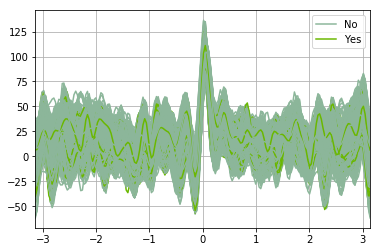

In [5]:
andrews_curves(Caravan, 'Purchase')

This Andrew's plot was my best attempt at trying to visualize the structure of this datset with many dimensions. The issue here is that it does not seem that this graph provides us with much useful data. 

C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  """


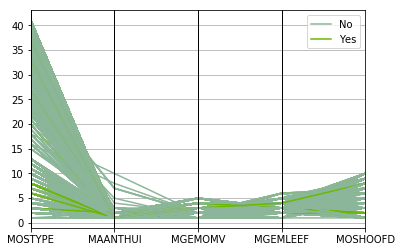

In [6]:
plt.figure()

pd.tools.plotting.parallel_coordinates(
    Caravan[[u'MOSTYPE', u'MAANTHUI', u'MGEMOMV', u'MGEMLEEF', u'MOSHOOFD',u'Purchase']], 
    'Purchase')


plt.show()

From this graph we can see imediately that the majority of our observations that bought have MOSTYPE variable from about 2 to 8. We can also see that a bunch of the purchases have a values of MGEMOMV of around 4

C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


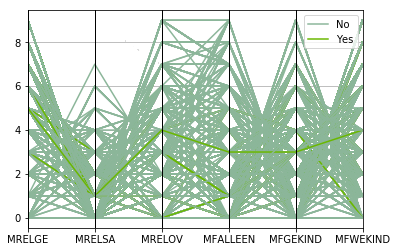

In [7]:
plt.figure()

pd.tools.plotting.parallel_coordinates(
    Caravan[[u'MRELGE', u'MRELSA',
       u'MRELOV', u'MFALLEEN', u'MFGEKIND', u'MFWEKIND',u'Purchase']], 
    'Purchase')


plt.show()

The MFALLEEN variable around 2.5 seems to be strong predictor of a sell as well as MRELSA around 1.5

If I had more time it might be useful to plot all of the data in little sections like this to determine which variables have tight grouping around a central value and which ones don't have this characteristic. From there we could try dropping those variables are comparing the subsequent model ROC scores.

# Preproccessing

The only thing done here is changing the Purchase variable from Yes and No to 0 for No and 1 for Yes. 

In [8]:
##changing column Purchase from class Purchase to class category
Caravan["Purchase"] = Caravan["Purchase"].astype('category')
##assign the encoded variables to new column
Caravan["Purchase_cat"] = Caravan["Purchase"].cat.codes

In [9]:
Caravan = Caravan.select_dtypes(include=['int8','int64']).copy()

In [10]:
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase_cat
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
3,39,2,3,2,9,2,2,0,5,7,...,0,0,0,0,0,0,0,0,0,0
4,33,1,2,4,8,0,1,3,6,6,...,0,0,0,0,0,0,0,0,0,0


# Partitioning the Dataset

In [11]:
X_Caravan = Caravan.drop('Purchase_cat', axis=1)
X_Caravan.shape

(4630, 85)

In [12]:
Y_Caravan =Caravan['Purchase_cat']
Y_Caravan.shape

(4630L,)

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_Caravan, Y_Caravan,
                                                random_state=66)

# Naive Bayes

In [14]:
                                           # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data


In [15]:
#Get accuracy score from model used above
accuracy_score(ytest, y_model)

0.14075993091537134

In [16]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5096231243317275

# Logistic Regression

In [17]:
logreg = LogisticRegression().fit(Xtrain, ytrain)
y_model = logreg.predict(Xtest)
print("Training set score: {:.3f}".format(logreg.score(Xtrain, ytrain)))
print("Test set score: {:.3f}".format(logreg.score(Xtest, ytest)))


Training set score: 0.941
Test set score: 0.934


In [18]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5060309718034047

In [19]:
logreg100 = LogisticRegression(C=100).fit(Xtrain, ytrain)
y_model = logreg.predict(Xtest)
print("Training set score: {:.3f}".format(logreg100.score(Xtrain, ytrain)))
print("Test set score: {:.3f}".format(logreg100.score(Xtest, ytest)))


Training set score: 0.940
Test set score: 0.932


In [20]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5060309718034047

In [21]:
logreg001 = LogisticRegression(C=0.01).fit(Xtrain, ytrain)
y_model = logreg.predict(Xtest)
print("Training set score: {:.3f}".format(logreg001.score(Xtrain, ytrain)))
print("Test set score: {:.3f}".format(logreg001.score(Xtest, ytest)))

Training set score: 0.940
Test set score: 0.934


In [22]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)


0.5060309718034047

# K Nearest Neighbors

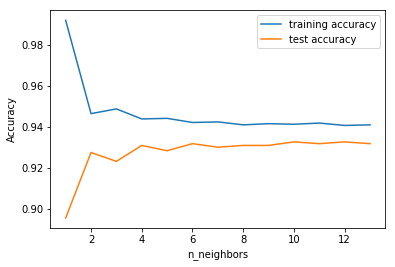

In [23]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 14
neighbors_settings = range(1, 14)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(Xtrain, ytrain)
    # record training set accuracy
    training_accuracy.append(clf.score(Xtrain, ytrain))
    # record generalization accuracy
    test_accuracy.append(clf.score(Xtest, ytest))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()


After looking at the graph comparing performance from k = 1 to 14 nearest neighbors it looks like 2, 4, 6 and 8 might be optimal.

In [24]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(Xtrain, ytrain)
y_model = clf.predict(Xtest)
print("Test set accuracy: {:.2f}".format(clf.score(Xtest, ytest)))

Test set accuracy: 0.93


In [25]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.4967622571692877

In [26]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(Xtrain, ytrain)
y_model = clf.predict(Xtest)
print("Test set accuracy: {:.2f}".format(clf.score(Xtest, ytest)))


Test set accuracy: 0.93


In [27]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)


0.49861239592969475

In [28]:
clf = KNeighborsClassifier(n_neighbors=6)
clf.fit(Xtrain, ytrain)
y_model = clf.predict(Xtest)
print("Test set accuracy: {:.2f}".format(clf.score(Xtest, ytest)))


Test set accuracy: 0.93


In [29]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5051059024232012

In [30]:
clf = KNeighborsClassifier(n_neighbors=8)
clf.fit(Xtrain, ytrain)
y_model = clf.predict(Xtest)
print("Test set accuracy: {:.2f}".format(clf.score(Xtest, ytest)))

Test set accuracy: 0.93


In [31]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.49861239592969475

Looks like a three way tie. Optionally we could change the random seed used to partition our data set if we wanted to more rigorously test these four options. However it is unlikely this will change the results significantly so we might as well randomly pick one of the options.

# Decision Tree

In [32]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(Xtrain, ytrain)
y_model = tree.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(tree.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(tree.score(Xtest, ytest)))

Accuracy on training set: 0.993
Accuracy on test set: 0.878


In [33]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5307074978675349

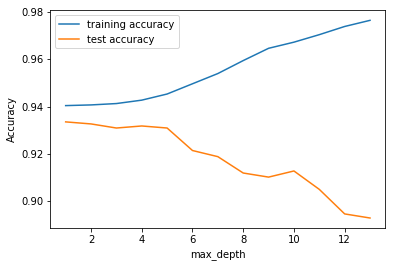

In [34]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 14
max_depth_settings = range(1, 14)

for max_depth in max_depth_settings:
    # build the model
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(Xtrain, ytrain)
    # record training set accuracy
    training_accuracy.append(clf.score(Xtrain, ytrain))
    # record generalization accuracy
    test_accuracy.append(clf.score(Xtest, ytest))
    
plt.plot(max_depth_settings, training_accuracy, label="training accuracy")
plt.plot(max_depth_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend()

Looks like max_depth at 1 looks optimal. Lets try it out

In [35]:
tree = DecisionTreeClassifier(max_depth=1, random_state=0)
tree.fit(Xtrain, ytrain)
y_model = tree.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(tree.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(tree.score(Xtest, ytest)))

Accuracy on training set: 0.940
Accuracy on test set: 0.934


In [36]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)


0.5

In [37]:
tree = DecisionTreeClassifier(max_depth=8, random_state=0)
tree.fit(Xtrain, ytrain)
y_model = tree.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(tree.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(tree.score(Xtest, ytest)))

Accuracy on training set: 0.959
Accuracy on test set: 0.916


In [38]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5269351370183933

Interestingly the accuracy score on the max_depth is higher at 1 than at 8 but the area under the roc curve is higher with max_depth = 8

# Random Forest

In [39]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(Xtrain, ytrain)
y_model = forest.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(forest.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(forest.score(Xtest, ytest)))

Accuracy on training set: 0.993
Accuracy on test set: 0.927


In [40]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5143926378894002

In [41]:
forest = RandomForestClassifier(n_estimators=6, random_state=0)
forest.fit(Xtrain, ytrain)
y_model = forest.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(forest.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(forest.score(Xtest, ytest)))

Accuracy on training set: 0.980
Accuracy on test set: 0.927


In [42]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5083616660859954

# Gradient Boosting Classifier

In [43]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(Xtrain, ytrain)
y_model = gbrt.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.949
Accuracy on test set: 0.928


In [44]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)


0.5153177072696036

In [45]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(Xtrain, ytrain)
y_model = gbrt.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.940
Accuracy on test set: 0.934


In [46]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5

In [47]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(Xtrain, ytrain)
y_model = gbrt.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(gbrt.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(Xtest, ytest)))

Accuracy on training set: 0.941
Accuracy on test set: 0.933


In [48]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)


0.49953746530989823

# Support Vector Machine

In [49]:
#DONT RUN (Unless you want to wait a really really really really long time)
#svc = SVC(C=1000)
#svc.fit(Xtrain, ytrain)
#
#print("Accuracy on training set: {:.2f}".format(svc.score(Xtrain, ytrain)))
#print("Accuracy on test set: {:.2f}".format(svc.score(Xtest, ytest)))

# Neural Nets

In [50]:
mlp = MLPClassifier(random_state=42)
mlp.fit(Xtrain, ytrain)
y_model = mlp.predict(Xtest)
print("Accuracy on training set: {:.2f}".format(mlp.score(Xtrain, ytrain)))
print("Accuracy on test set: {:.2f}".format(mlp.score(Xtest, ytest)))

Accuracy on training set: 0.95
Accuracy on test set: 0.92


In [51]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5009430902122853

In [52]:
# compute the mean value per feature on the training set
mean_on_train = Xtrain.mean(axis=0)
# compute the standard deviation of each feature on the training set
std_on_train = Xtrain.std(axis=0)

# subtract the mean, and scale by inverse standard deviation
# afterward, mean=0 and std=1
X_train_scaled = (Xtrain - mean_on_train) / std_on_train
# use THE SAME transformation (using training mean and std) on the test set
X_test_scaled = (Xtest - mean_on_train) / std_on_train


In [53]:
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, ytrain)
y_model = mlp.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, ytrain)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, ytest)))

Accuracy on training set: 0.981
Accuracy on test set: 0.915


In [54]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5418083304299771

In [55]:
mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train_scaled, ytrain)
y_model = mlp.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, ytrain)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, ytest)))

Accuracy on training set: 0.981
Accuracy on test set: 0.915


In [56]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.5418083304299771

In [57]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, ytrain)
y_model = mlp.predict(Xtest)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, ytrain)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, ytest)))

Accuracy on training set: 0.947
Accuracy on test set: 0.929


In [58]:
#get area under roc curve from model used above
roc_auc_score(ytest, y_model)

0.560363780530293

# Getting a list of the top 50 clients

In [59]:
Caravan_unk = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/Caravan_unk.csv")

In [60]:
#probs = logreg.predict_proba(Caravan_unk)[:,1]
probs = mlp.predict_proba(Caravan_unk)[:,1] #Use mlp model to predict likelihood of each the [:,1] specifies column 2 which 
                                            #has liklihood for Yes purchase decision
probs

array([0.00522536, 0.00665952, 0.87800416, ..., 0.00608473, 0.00239275,
       0.00687612])

In [61]:
probs = pd.DataFrame(probs)
probs.columns = probs.columns +1
probs.index = probs.index 
probs.dtypes

1    float64
dtype: object

In [62]:
done = pd.merge(Caravan_unk, probs, left_index=True, right_index=True)
done.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,1
0,41,1,3,3,10,0,7,0,3,8,...,0,0,0,1,0,1,0,0,0,0.005225
1,38,1,3,2,9,0,6,0,3,5,...,0,0,0,0,0,0,0,0,0,0.006660
2,1,1,4,3,1,1,5,1,3,6,...,0,0,0,1,0,0,0,0,0,0.878004
3,38,1,3,2,9,2,2,2,4,7,...,0,0,1,0,0,0,0,0,0,0.033303
4,35,1,2,3,8,1,5,1,3,5,...,0,0,0,1,0,0,0,0,0,0.066137


In [63]:
sorteddone = done.sort_values(by=[1L], ascending=False) #sort by most likely
proba =sorteddone[1L] #only the probabilities

In [64]:
probasort = proba.head(n=50) #Just the top 50

In [65]:
probasort.sort_index() #Sorts top 50 by index number

2       0.878004
11      0.626868
20      0.837854
26      0.626868
28      0.635889
29      0.720323
30      0.881402
31      0.780058
34      0.643255
44      0.741234
51      0.899684
57      0.811866
65      0.650757
109     0.650755
113     0.702039
134     0.650754
156     0.661446
235     0.651796
241     0.609745
247     0.609915
285     0.668328
306     0.655483
329     0.720379
332     0.605877
354     0.835238
389     0.847796
402     0.779353
403     0.792825
414     0.815771
423     0.800034
467     0.830305
525     0.689091
527     0.734055
644     0.667383
651     0.816891
687     0.639918
715     0.613837
732     0.683381
738     0.881179
765     0.648060
835     0.641775
849     0.602783
853     0.640384
868     0.702078
872     0.639922
912     0.627710
921     0.613096
952     0.672637
975     0.713081
1059    0.610337
Name: 1, dtype: float64